**TO DO**  
-follow this tutorial to handle date data: https://ibexorigin.medium.com/in-depth-guide-to-building-custom-sklearn-transformers-for-any-data-preprocessing-scenario-33450f8b35ff  
-Tune the model  
-Test other fill methods

In [1]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
import pickle
from langdetect import detect
%load_ext autoreload
%autoreload 2

In [2]:
with open("./listings.pkl", "rb") as fh:
    data = pickle.load(fh)
with open("./test_listings_overall.pkl", "rb") as fh:
    data_test = pickle.load(fh)

In [3]:
data

,Are Pets Allowed,Category Idx,Day of Advertisement Created,Day of Date Available From,Demand,Floor,Geo Canton,Geo City,Geo Zip,Has Balcony,...,Number of Images,Price Extra Normalized,Price Gross Normalized,Price M2 Normalized,Price Net Normalized,Property Reference Id,Size M2 Normalized,Subcategory En Idx,Year Built,Year Lastrenovated
0,NaN,APPT,"January 7, 2021","March 1, 2021",25.0,0.0,ZH,Dübendorf,8600,NaN,...,6,550.0,4460.0,19.0,3910.0,0002.03.7648,232.0,Apartment,2016.0,2016.0
1,NaN,APPT,"November 18, 2019","March 1, 2020",2.0,1.0,VD,Le Mont-sur-Lausanne,1052,NaN,...,7,120.0,1345.0,30.0,1225.0,9680.61.2071,45.0,Apartment,NaN,NaN
2,False,APPT,"March 15, 2017",NaN,0.0,1.0,BE,Langenthal,4900,False,...,13,250.0,1570.0,15.0,1320.0,7204.61.8658,103.0,Apartment,NaN,NaN
3,True,APPT,"July 7, 2021","May 1, 2021",4.0,1.0,AG,Fislisbach,5442,NaN,...,13,270.0,1480.0,17.0,1210.0,7410.50.5987,86.0,Apartment,1985.0,1985.0
4,False,APPT,"November 3, 2017","August 1, 2017",3.0,0.0,FR,Bulle,1630,False,...,3,300.0,1490.0,19.0,1190.0,9270.61.7822,79.0,Apartment,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,False,APPT,"January 4, 2018","April 1, 2018",2.0,2.0,SG,St. Gallen,9000,False,...,6,170.0,1350.0,15.0,1180.0,4458.50.0065,90.0,Apartment,NaN,NaN
19996,True,APPT,"November 3, 2021","February 1, 2022",1.0,2.0,VD,Vevey,1800,NaN,...,8,190.0,1940.0,23.0,1750.0,4481.61.5904,84.0,Apartment,1968.0,1968.0
19997,NaN,APPT,"October 15, 2021","June 16, 2021",2.0,5.0,GE,Grand-Lancy,1212,NaN,...,5,275.0,2175.0,32.0,1900.0,0221.61.7685,68.0,Apartment,NaN,NaN
19998,NaN,APPT,"October 1, 2020","May 1, 2021",2.0,7.0,VD,Nyon,1260,NaN,...,6,240.0,3540.0,37.0,3300.0,8508.50.4399,95.0,Apartment,NaN,NaN


In [4]:
data_test=data_test.drop('Prediction',axis=1)

<AxesSubplot:>

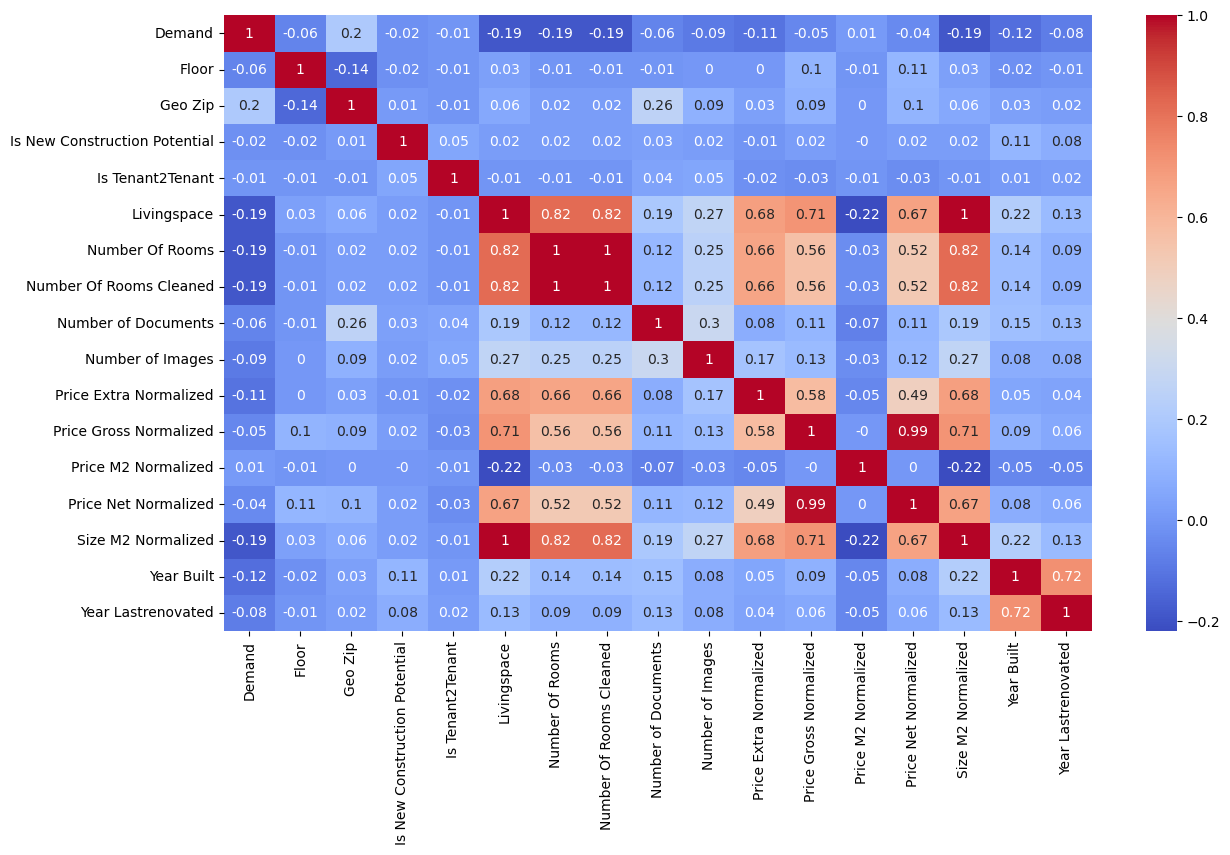

In [5]:
# Plot the correlation heatmap
plt.figure(figsize=(14, 8))
corr_matrix = data.corr().round(2)
sns.heatmap(data=corr_matrix,cmap='coolwarm',annot=True)

**Conclusion** We should remove one of the corrolated variables ex: remove Number of Rooms Cleaned, Livingscapce Price net normalized

# Data Cleaning

There are some things to consider before starting using the random forest:  
1-**How to deal with NaN**  
  Answer: check if there are NaN in test set, if yes can make a category for NaN?  
          What does NaN mean? Customer doesn't have access to the information? Or we don't know if he had access to it?  
2-**How to deal with categorical variables**  
  One hot encoding, but beware of having too many categories.  
  Testing without categorical variables?  

## Identifying categorical and categorical variables

In [6]:
#identifying the boolean variables
bool_features=['Are Pets Allowed', 'Has Balcony', 'Has Cabletv',
               'Has Elevator', 'Has Fireplace', 'Has Garage',
               'Has Parking', 'Is New Construction', 'Is New Construction Potential', 
               'Is Tenant2Tenant', 'Is Wheelchairaccessible']
print(bool_features)
data_bool=data[bool_features]

['Are Pets Allowed', 'Has Balcony', 'Has Cabletv', 'Has Elevator', 'Has Fireplace', 'Has Garage', 'Has Parking', 'Is New Construction', 'Is New Construction Potential', 'Is Tenant2Tenant', 'Is Wheelchairaccessible']


Identifying other categorical (and non ordinal ex: Number of Rooms, Price Extra Normalized or even Year Built...) variables with not so many categories

In [7]:
data.nunique()[data.nunique()>2]

Day of Advertisement Created     1483
Day of Date Available From        255
Demand                            172
Floor                              22
Geo Canton                         24
Geo City                          392
Geo Zip                           450
Listing Description             17822
Listing Title                   11224
Livingspace                       206
Number Of Rooms                    19
Number Of Rooms Cleaned            19
Number of Documents                 3
Number of Images                   14
Price Extra Normalized            413
Price Gross Normalized           1873
Price M2 Normalized               157
Price Net Normalized             1410
Property Reference Id           14699
Size M2 Normalized                205
Subcategory En Idx                 12
Year Built                        143
Year Lastrenovated                136
dtype: int64

In [8]:
#This feature is not supposed to be useful for regression purpose
data['Property Reference Id']

0        0002.03.7648
1        9680.61.2071
2        7204.61.8658
3        7410.50.5987
4        9270.61.7822
             ...     
19995    4458.50.0065
19996    4481.61.5904
19997    0221.61.7685
19998    8508.50.4399
19999    4893.61.5829
Name: Property Reference Id, Length: 20000, dtype: object

### Investigating the NaN

In [10]:
null_count=pd.concat([data.isnull().sum().rename('NaN train set'),data_test.isnull().sum().rename('NaN test set')],axis=1)
null_count

,NaN train set,NaN test set
Are Pets Allowed,9267,4554.0
Demand,0,NaN
Floor,7,4.0
Has Balcony,12110,5962.0
Has Cabletv,7151,3561.0
Has Elevator,7585,3728.0
Has Fireplace,12179,6022.0
Has Garage,8281,4096.0
Has Parking,9209,4607.0
Is New Construction,11058,5561.0


**Conclusion**: We see that test data have nan for the same attributes as for train data, so for categorical variables we can encode nan as a category

We then see that there are NaN values for ordinal features, this is bad as we can't add a category for ordinal values. We will have to fill them by the mean of the other values in the column for example

In [13]:
#null_count.loc[ordinal_features]

In [14]:
#null_count.loc[bool_features]

# Random Forest

In [50]:
#https://towardsdatascience.com/predicting-housing-prices-using-a-scikit-learns-random-forest-model-e736b59d56c5
#https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import sklearn
from sklearn.metrics import mean_squared_error
from custom_scorer_module import custom_accuracy
from sklearn.metrics import fbeta_score, make_scorer


## Transformer to deal with NaN

In [16]:
#DEALING WITH NAN
def fill_nan(X: pd.DataFrame,bool_features,ordinal_features,bool_fill=-99999, y=None):
    df=X.copy() #We don't want to modify the dataset
    
    #Dealing with categorical values
    for bool_feature in bool_features:
        df.loc[:,bool_feature]=df.loc[:,bool_feature].fillna(bool_fill)
        df.loc[df[bool_feature] == False, bool_feature] = 0
        df.loc[data[bool_feature] == True, bool_feature] = 1
    
    #Dealing with ordinal values
    for ordinal_feature in ordinal_features:
        df[ordinal_feature].fillna(df[ordinal_feature].mean(),inplace=True)
    return df

na_fill_estimator = FunctionTransformer(fill_nan,kw_args={'bool_features':bool_features,
                                                          'ordinal_features':ordinal_features})

print('NaN cleaning:')
display(na_fill_estimator.transform(data))





NaN cleaning:


,Are Pets Allowed,Demand,Floor,Has Balcony,Has Cabletv,Has Elevator,Has Fireplace,Has Garage,Has Parking,Is New Construction,...,Number Of Rooms Cleaned,Number of Documents,Number of Images,Price Extra Normalized,Price Gross Normalized,Price M2 Normalized,Price Net Normalized,Size M2 Normalized,Year Built,Year Lastrenovated
0,-99999,25.0,0.0,-99999,-99999,-99999,-99999,-99999,-99999,0,...,9.5,1,6,550.0,4460.0,19.0,3910.0,232.0,2016.000000,2016.000000
1,-99999,2.0,1.0,-99999,-99999,-99999,-99999,-99999,-99999,-99999,...,2.5,0,7,120.0,1345.0,30.0,1225.0,45.0,1976.683963,1991.791096
2,0,0.0,1.0,0,0,0,0,0,0,-99999,...,3.5,1,13,250.0,1570.0,15.0,1320.0,103.0,1976.683963,1991.791096
3,1,4.0,1.0,-99999,1,-99999,-99999,1,1,0,...,3.5,1,13,270.0,1480.0,17.0,1210.0,86.0,1985.000000,1985.000000
4,0,3.0,0.0,0,0,0,0,0,0,-99999,...,3.5,0,3,300.0,1490.0,19.0,1190.0,79.0,1976.683963,1991.791096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,2.0,2.0,0,0,0,0,0,0,-99999,...,4.5,1,6,170.0,1350.0,15.0,1180.0,90.0,1976.683963,1991.791096
19996,1,1.0,2.0,-99999,1,1,-99999,1,1,0,...,3.0,0,8,190.0,1940.0,23.0,1750.0,84.0,1968.000000,1968.000000
19997,-99999,2.0,5.0,-99999,-99999,-99999,-99999,-99999,-99999,-99999,...,4.0,0,5,275.0,2175.0,32.0,1900.0,68.0,1976.683963,1991.791096
19998,-99999,2.0,7.0,-99999,-99999,-99999,-99999,-99999,-99999,-99999,...,4.5,1,6,240.0,3540.0,37.0,3300.0,95.0,1976.683963,1991.791096


## Transformer to one hot encode the categorical values

In [17]:
features_to_encode=bool_features
col_trans = make_column_transformer(
                        (OneHotEncoder(),features_to_encode),
                        remainder = "passthrough"
                        )
print('One Hot Encoded data:')
print(col_trans.fit_transform(na_fill_estimator.transform(data)))
print(col_trans.fit_transform(na_fill_estimator.transform(data)).shape)

One Hot Encoded data:
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.32000000e+02
  2.01600000e+03 2.01600000e+03]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.50000000e+01
  1.97668396e+03 1.99179110e+03]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 1.03000000e+02
  1.97668396e+03 1.99179110e+03]
 ...
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.80000000e+01
  1.97668396e+03 1.99179110e+03]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.50000000e+01
  1.97668396e+03 1.99179110e+03]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 5.20000000e+01
  1.97668396e+03 1.99179110e+03]]
(20000, 45)


## Define the RandomForest model and create a pipeline to join everything:

In [20]:
rf_regressor=RandomForestClassifier(oob_score=True,
                      n_jobs=-1)
pipe = make_pipeline(na_fill_estimator, col_trans,rf_regressor)
#cross_val_score(pipe,X,y,cv=5,scoring='RMSE')

## Testing our model:

In [21]:
#Generating test and train set
X=data.drop(['Demand'],axis=1)
y=data['Demand']
seed = 50  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.333, random_state = seed)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(18000, 24) (18000,) (2000, 24) (2000,)


In [22]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function fill_nan at 0x000002E5615BDE50>,
                                     kw_args={'bool_features': ['Are Pets '
                                                                'Allowed',
                                                                'Has Balcony',
                                                                'Has Cabletv',
                                                                'Has Elevator',
                                                                'Has Fireplace',
                                                                'Has Garage',
                                                                'Has Parking',
                                                                'Is New '
                                                                'Construction',
                                                                'Is New '
                    

In [101]:
#print(rf_regressor.feature_importances_)
#print(len(rf_regressor.feature_importances_))

We notice that there are more importance than features because of the one hot encoding

In [102]:
# Let's look at the first row
#print(col_trans.fit_transform(na_fill_estimator.transform(X_train))[0,:]) 

In [103]:
#na_fill_estimator.transform(X_train).iloc[0]

All the encoded categorical variables are shown first, followed by the numeric variables in the one hot encoded version of X_train?

In [23]:
def encode_and_bind(original_dataframe, features_to_encode):    
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)
X_train_encoded = encode_and_bind(na_fill_estimator.transform(X_train), features_to_encode)

C:\Users\Corentin\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [25]:
#X_train_encoded

In [26]:
feature_importances = list(zip(X_train_encoded, rf_regressor.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
#[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];

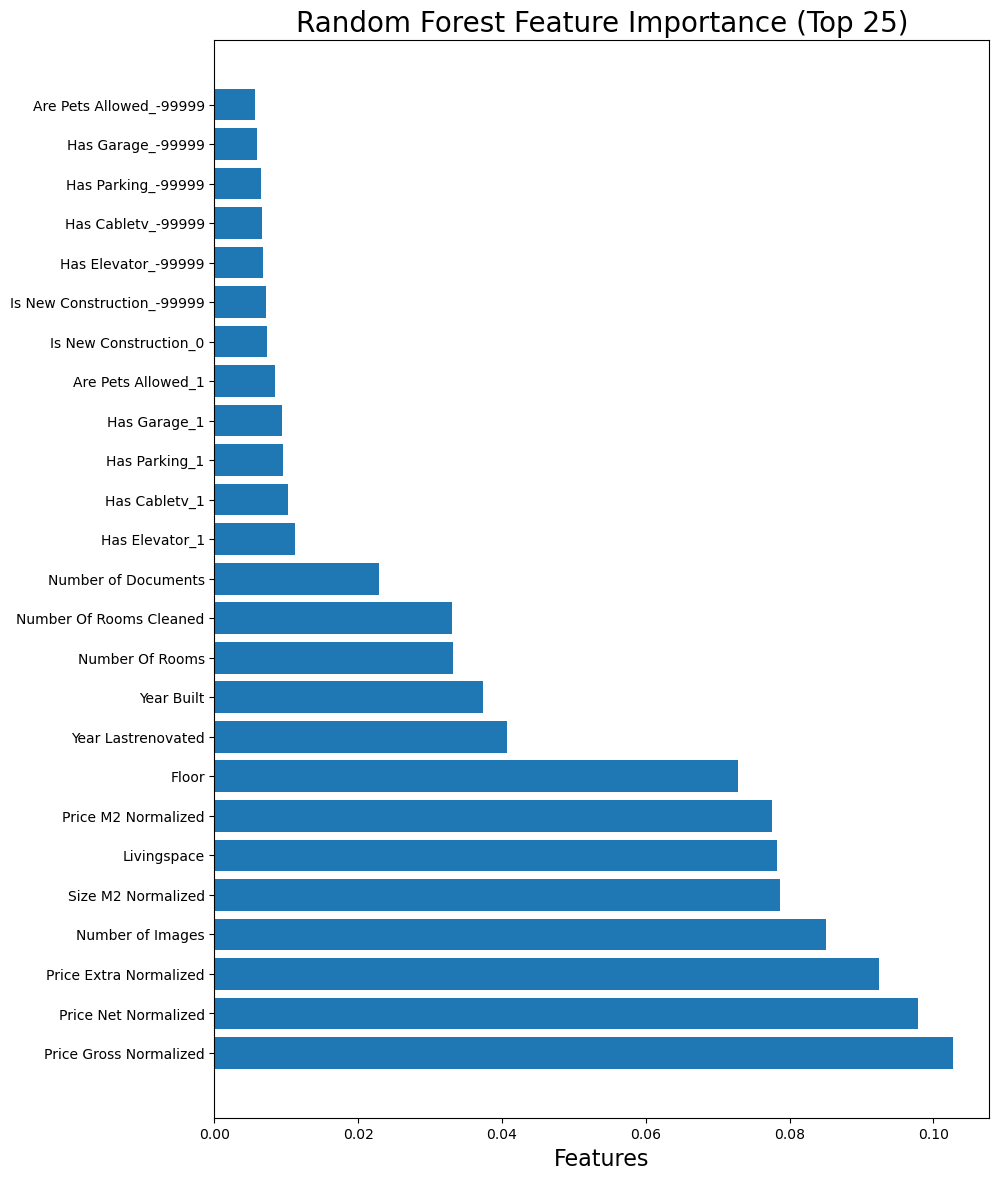

In [27]:
# Plot the top 25 feature importance
feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance (Top 25)',
          fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

# Evaluate the model

In [28]:
def accuracy(y_pred,y,tol=0):
    numpy_y=y.to_numpy()
    rounded_y_pred=y_pred.round()
    assert len(rounded_y_pred)==len(numpy_y)
    return (np.abs(rounded_y_pred-numpy_y)<=tol).sum()/len(rounded_y_pred)

In [29]:
y_pred = pipe.predict(X_test)

In [30]:
print('In Sample accuracy for tol \n0: {:.2f}, \n1 {:.2f} ,\n2 {:.2f} ,\n3 {:.2f}'.format(*[accuracy( pipe.predict(X_train),y_train,tol=i) for i in range(0,4)]))
print('In sample RMSE {:.2f}'.format(mean_squared_error(pipe.predict(X_train),y_train,squared=False)))
print('Out of Sample accuracy for tol \n0: {:.2f}, \n1 {:.2f} ,\n2 {:.2f} ,\n3 {:.2f}'.format(*[accuracy( pipe.predict(X_test),y_test,tol=i) for i in range(0,4)]))
print('Out of Sample RMSE {:.2f}'.format(mean_squared_error(pipe.predict(X_test),y_test,squared=False)))

In Sample accuracy for tol 
0: 0.93, 
1 0.95 ,
2 0.96 ,
3 0.97
In sample RMSE 3.39
Out of Sample accuracy for tol 
0: 0.20, 
1 0.41 ,
2 0.54 ,
3 0.63
Out of Sample RMSE 15.65


# Random forest without one hot encoding

In [31]:
pipe= make_pipeline(na_fill_estimator,rf_regressor)
pipe.fit(X_train,y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function fill_nan at 0x000002E5615BDE50>,
                                     kw_args={'bool_features': ['Are Pets '
                                                                'Allowed',
                                                                'Has Balcony',
                                                                'Has Cabletv',
                                                                'Has Elevator',
                                                                'Has Fireplace',
                                                                'Has Garage',
                                                                'Has Parking',
                                                                'Is New '
                                                                'Construction',
                                                                'Is New '
                    

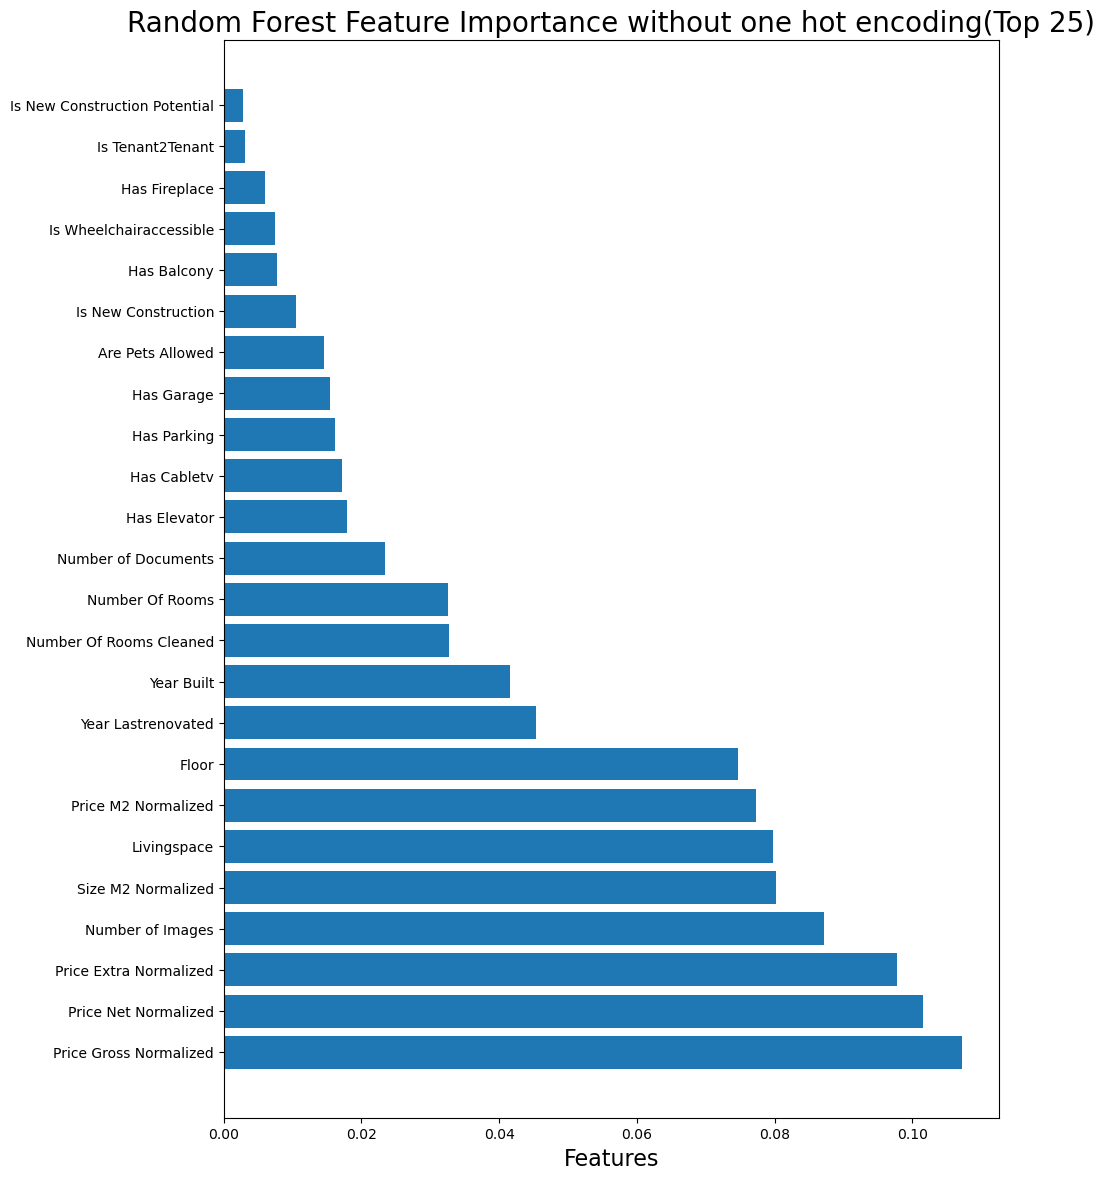

In [32]:
feature_importances = list(zip(X_train, rf_regressor.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Plot the top 25 feature importance
feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance without one hot encoding(Top 25)',
          fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

In [33]:
y_pred = pipe.predict(X_test)
print('In Sample accuracy for tol \n0: {:.2f}, \n1 {:.2f} ,\n2 {:.2f} ,\n3 {:.2f}'.format(*[accuracy( pipe.predict(X_train),y_train,tol=i) for i in range(0,4)]))
print('In sample RMSE {:.2f}'.format(mean_squared_error(pipe.predict(X_train),y_train,squared=False)))
print('Out of Sample accuracy for tol \n0: {:.2f}, \n1 {:.2f} ,\n2 {:.2f} ,\n3 {:.2f}'.format(*[accuracy( pipe.predict(X_test),y_test,tol=i) for i in range(0,4)]))
print('Out of Sample RMSE {:.2f}'.format(mean_squared_error(pipe.predict(X_test),y_test,squared=False)))

In Sample accuracy for tol 
0: 0.93, 
1 0.95 ,
2 0.96 ,
3 0.97
In sample RMSE 3.40
Out of Sample accuracy for tol 
0: 0.20, 
1 0.40 ,
2 0.53 ,
3 0.62
Out of Sample RMSE 14.90


**Conclusion** One hot encoding leads to similar results as not one hot encoding for bool categorical variables

# Dropping the corrolated features

In [34]:
#Removing size M2 Normalized, Number of Rooms and all price measure except extra price normalized:
ordinal_features=['Floor','Livingspace', 
       'Number Of Rooms Cleaned', 'Number of Documents', 'Number of Images',
       'Price Extra Normalized', 'Year Built',
       'Year Lastrenovated']

In [35]:
#DEALING WITH NAN
def drop_column(X: pd.DataFrame,columns, y=None):
    X_copy=X.copy() #We don't want to modify the dataset
    X_copy.drop(columns,axis=1,inplace=True)
    
    return X_copy

drop_col_transformer = FunctionTransformer(drop_column,kw_args={'columns':['Price M2 Normalized','Price Gross Normalized',
                                                                           'Price Net Normalized','Size M2 Normalized',
                                                                           'Number Of Rooms']})
na_fill_estimator = FunctionTransformer(fill_nan,kw_args={'bool_features':bool_features,
                                                          'ordinal_features':ordinal_features})

## 1 With One Hot encoding

In [36]:
pipe= make_pipeline(drop_col_transformer,na_fill_estimator,col_trans,rf_regressor)
pipe.fit(X_train,y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function drop_column at 0x000002E56EF16310>,
                                     kw_args={'columns': ['Price M2 Normalized',
                                                          'Price Gross '
                                                          'Normalized',
                                                          'Price Net '
                                                          'Normalized',
                                                          'Size M2 Normalized',
                                                          'Number Of Rooms']})),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function fill_nan at 0x000002E5615BDE50>,
                                     kw_args={'bool_features': [...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                  

C:\Users\Corentin\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


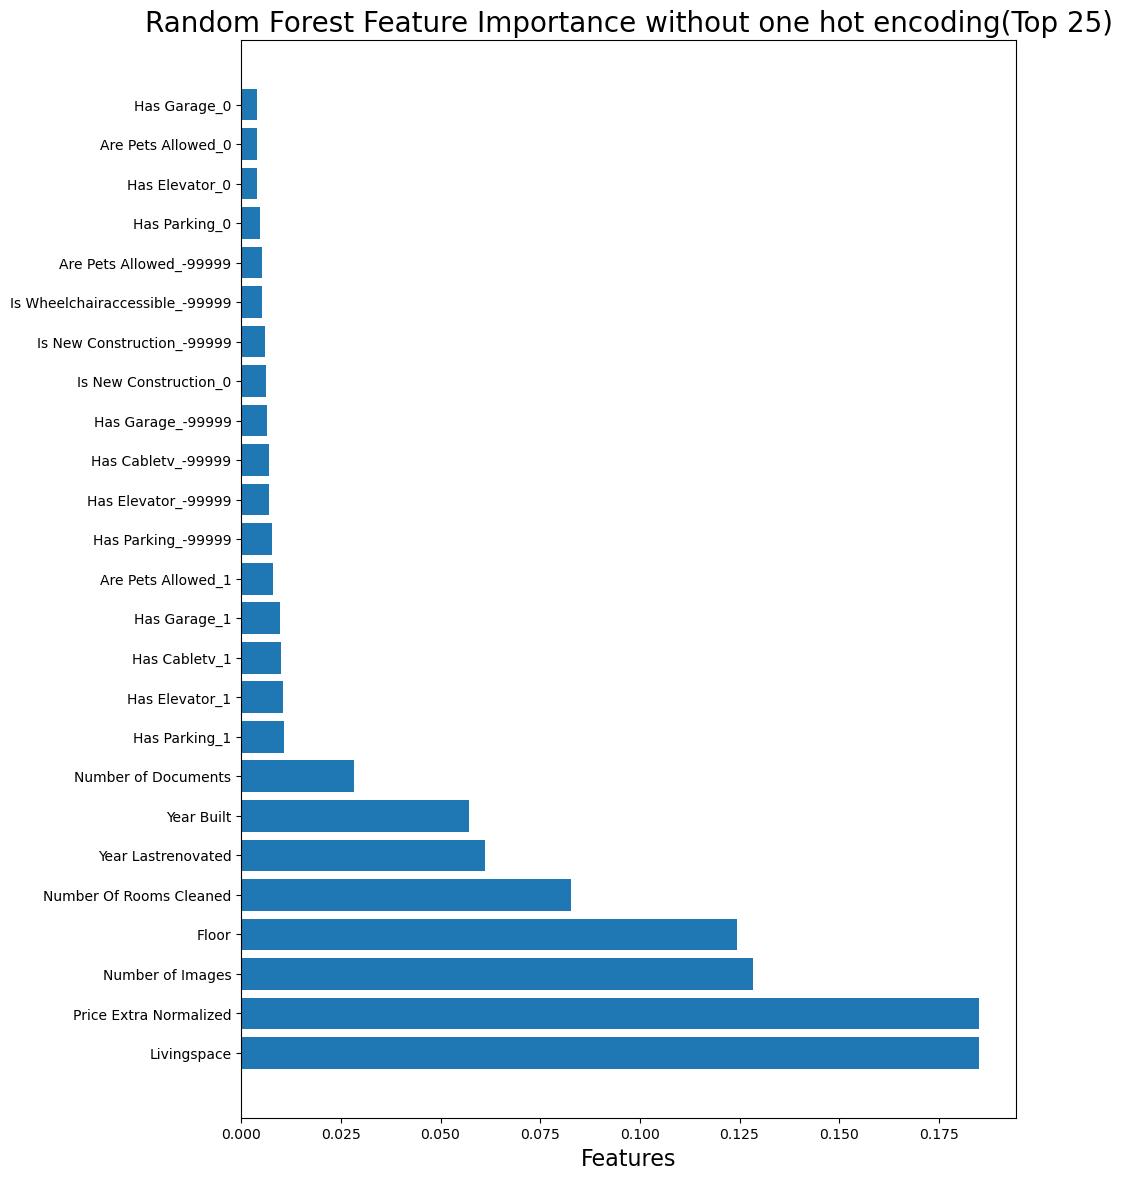

In [37]:
X_train_encoded = encode_and_bind(na_fill_estimator.transform(drop_col_transformer.transform(X_train)), features_to_encode)
feature_importances = list(zip(X_train_encoded, rf_regressor.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Plot the top 25 feature importance
feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance without one hot encoding(Top 25)',
          fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

In [38]:
y_pred = pipe.predict(X_test)
print('In Sample accuracy for tol \n0: {:.2f}, \n1 {:.2f} ,\n2 {:.2f} ,\n3 {:.2f}'.format(*[accuracy( pipe.predict(X_train),y_train,tol=i) for i in range(0,4)]))
print('In sample RMSE {:.2f}'.format(mean_squared_error(pipe.predict(X_train),y_train,squared=False)))
print('Out of Sample accuracy for tol \n0: {:.2f}, \n1 {:.2f} ,\n2 {:.2f} ,\n3 {:.2f}'.format(*[accuracy( pipe.predict(X_test),y_test,tol=i) for i in range(0,4)]))
print('Out of Sample RMSE {:.2f}'.format(mean_squared_error(pipe.predict(X_test),y_test,squared=False)))

In Sample accuracy for tol 
0: 0.92, 
1 0.94 ,
2 0.96 ,
3 0.97
In sample RMSE 3.70
Out of Sample accuracy for tol 
0: 0.20, 
1 0.38 ,
2 0.51 ,
3 0.60
Out of Sample RMSE 16.04


## 2 Without One Hot encoding

In [39]:
pipe= make_pipeline(drop_col_transformer,na_fill_estimator,rf_regressor)
pipe.fit(X_train,y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function drop_column at 0x000002E56EF16310>,
                                     kw_args={'columns': ['Price M2 Normalized',
                                                          'Price Gross '
                                                          'Normalized',
                                                          'Price Net '
                                                          'Normalized',
                                                          'Size M2 Normalized',
                                                          'Number Of Rooms']})),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function fill_nan at 0x000002E5615BDE50>,
                                     kw_args={'bool_features': [...
                                                                'Is New '
                                                                'Constr

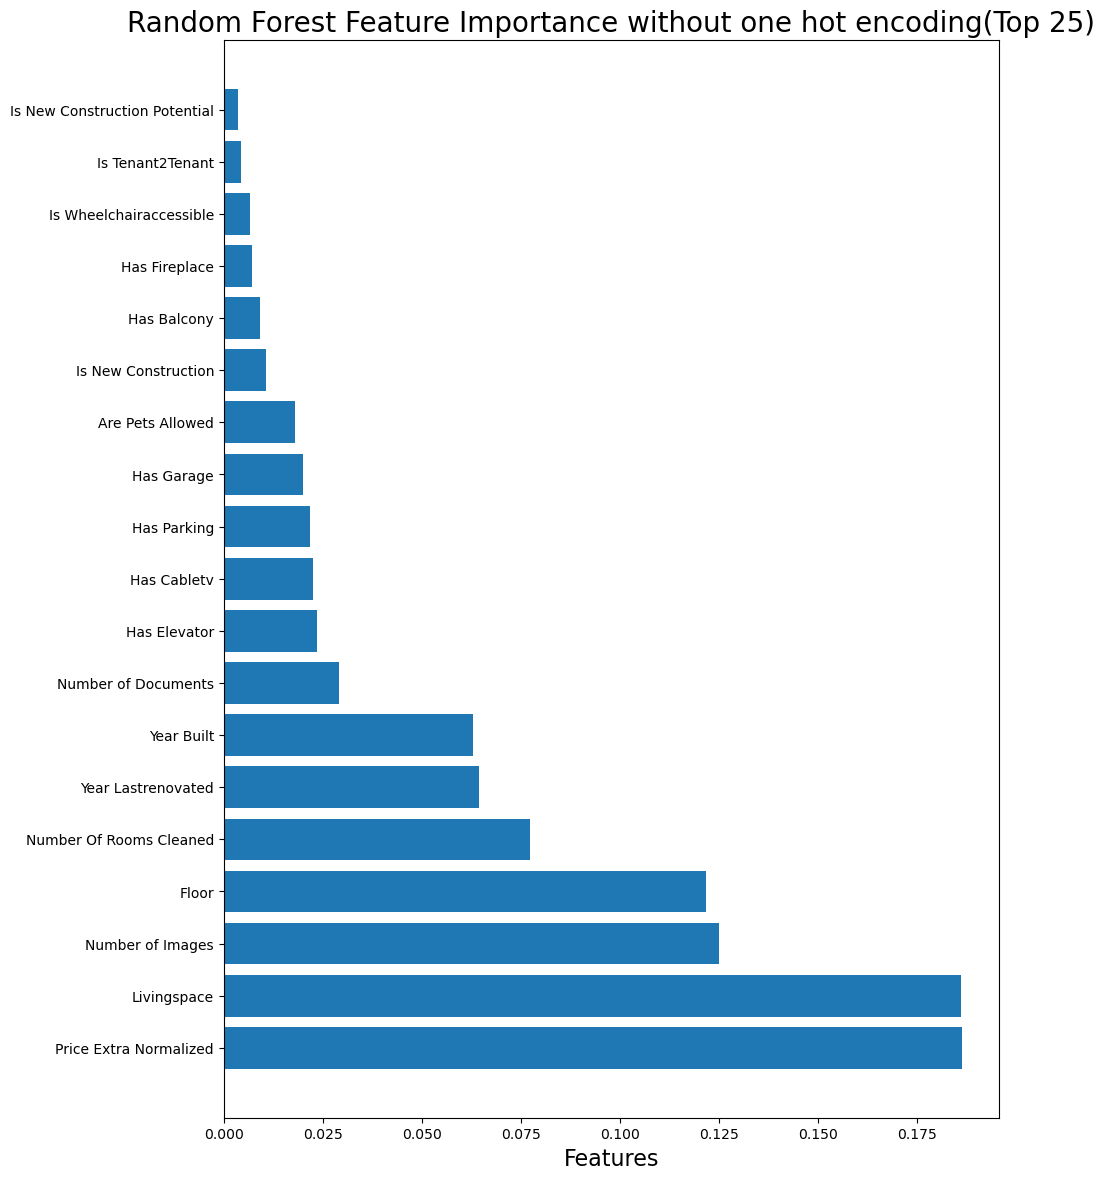

In [40]:
feature_importances = list(zip(drop_col_transformer.transform(X_train), rf_regressor.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Plot the top 25 feature importance
feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance without one hot encoding(Top 25)',
          fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

In [41]:
y_pred = pipe.predict(X_test)
print('In Sample accuracy for tol \n0: {:.2f}, \n1 {:.2f} ,\n2 {:.2f} ,\n3 {:.2f}'.format(*[accuracy( pipe.predict(X_train),y_train,tol=i) for i in range(0,4)]))
print('In sample RMSE {:.2f}'.format(mean_squared_error(pipe.predict(X_train),y_train,squared=False)))
print('Out of Sample accuracy for tol \n0: {:.2f}, \n1 {:.2f} ,\n2 {:.2f} ,\n3 {:.2f}'.format(*[accuracy( pipe.predict(X_test),y_test,tol=i) for i in range(0,4)]))
print('Out of Sample RMSE {:.2f}'.format(mean_squared_error(pipe.predict(X_test),y_test,squared=False)))

In Sample accuracy for tol 
0: 0.92, 
1 0.94 ,
2 0.96 ,
3 0.97
In sample RMSE 3.69
Out of Sample accuracy for tol 
0: 0.19, 
1 0.37 ,
2 0.51 ,
3 0.60
Out of Sample RMSE 14.82


**Conclusion** Dropping the corrolated features didn't improve accuracy

# Tuning the Random Forest Model

In [42]:
from pprint import pprint
print('Parameters currently in use:\n')
pprint(rf_regressor.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [43]:
from sklearn.model_selection import RandomizedSearchCV
max_features = [0.5,'auto', 'sqrt','log2']
min_samples_leaf = [1, 2, 4]
bootstrap = [True]
random_grid = {'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [51]:
scoring=make_scorer(custom_accuracy, tol=0,greater_is_better=True)
rf = RandomForestClassifier(oob_score=True, n_jobs=-1)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3,                
                               verbose=10,      scoring=scoring)
pipe_random = make_pipeline(drop_col_transformer,na_fill_estimator,col_trans, rf_random)
pipe_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=48, min_samples_leaf=4, min_samples_split=2, n_estimators=197


C:\Users\Corentin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV 1/3; 1/10] END bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=48, min_samples_leaf=4, min_samples_split=2, n_estimators=197;, score=0.223 total time=   7.4s
[CV 2/3; 1/10] START bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=48, min_samples_leaf=4, min_samples_split=2, n_estimators=197
[CV 2/3; 1/10] END bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=48, min_samples_leaf=4, min_samples_split=2, n_estimators=197;, score=0.225 total time=   4.9s
[CV 3/3; 1/10] START bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=48, min_samples_leaf=4, min_samples_split=2, n_estimators=197
[CV 3/3; 1/10] END bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=48, min_samples_leaf=4, min_samples_split=2, n_estimators=197;, score=0.225 total time=   5.2s
[CV 1/3; 2/10] START bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=10, n_estimators=467
[CV 1/3; 2/10

[CV 3/3; 9/10] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=36, min_samples_leaf=10, min_samples_split=10, n_estimators=504;, score=0.225 total time=   6.8s
[CV 1/3; 10/10] START bootstrap=True, max_depth=60, max_features=log2, max_leaf_nodes=49, min_samples_leaf=4, min_samples_split=10, n_estimators=516
[CV 1/3; 10/10] END bootstrap=True, max_depth=60, max_features=log2, max_leaf_nodes=49, min_samples_leaf=4, min_samples_split=10, n_estimators=516;, score=0.223 total time=   6.8s
[CV 2/3; 10/10] START bootstrap=True, max_depth=60, max_features=log2, max_leaf_nodes=49, min_samples_leaf=4, min_samples_split=10, n_estimators=516
[CV 2/3; 10/10] END bootstrap=True, max_depth=60, max_features=log2, max_leaf_nodes=49, min_samples_leaf=4, min_samples_split=10, n_estimators=516;, score=0.227 total time=   6.4s
[CV 3/3; 10/10] START bootstrap=True, max_depth=60, max_features=log2, max_leaf_nodes=49, min_samples_leaf=4, min_samples_split=10, n_estimators=516
[CV 3/3; 10/1

{'n_estimators': 467,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_leaf_nodes': 35,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [52]:
best_model = rf_random.best_estimator_
pipe = make_pipeline(drop_col_transformer,na_fill_estimator,col_trans, best_model)
pipe.fit(X_train, y_train)
y_pred= pipe.predict(X_test)

In [53]:
print('In Sample accuracy for tol \n0: {:.2f}, \n1 {:.2f} ,\n2 {:.2f} ,\n3 {:.2f}'.format(*[accuracy( pipe.predict(X_train),y_train,tol=i) for i in range(0,4)]))
print('In sample RMSE {:.2f}'.format(mean_squared_error(pipe.predict(X_train),y_train,squared=False)))
print('Out of Sample accuracy for tol \n0: {:.2f}, \n1 {:.2f} ,\n2 {:.2f} ,\n3 {:.2f}'.format(*[accuracy( pipe.predict(X_test),y_test,tol=i) for i in range(0,4)]))
print('Out of Sample RMSE {:.2f}'.format(mean_squared_error(pipe.predict(X_test),y_test,squared=False)))

In Sample accuracy for tol 
0: 0.23, 
1 0.37 ,
2 0.46 ,
3 0.54
In sample RMSE 20.37
Out of Sample accuracy for tol 
0: 0.22, 
1 0.36 ,
2 0.48 ,
3 0.56
Out of Sample RMSE 18.55
